In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.linear_model import LogisticRegression

In [6]:
filename = './data/anticoncepcion_indonesia.csv'
indonesia = pd.read_csv(filename)

In [ ]:
indonesia.columns

Index(['edad_mujer', 'educacion_mujer', 'educacion_hombre', 'numero_hijos',
       'religion_mujer', 'mujer_trabaja', 'ocupacion_hombre', 'nivel_vida',
       'exposicion_medios', 'metodo_anticonceptivo'],
      dtype='object')

In [ ]:
indonesia.isnull().values.any()

False

In [ ]:
indonesia.shape

(296, 10)

In [ ]:
indonesia.describe()

,edad_mujer,educacion_mujer,educacion_hombre,numero_hijos,religion_mujer,mujer_trabaja,ocupacion_hombre,nivel_vida,exposicion_medios,metodo_anticonceptivo
count,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,32.408784,3.016892,3.462838,3.179054,0.888514,0.746622,2.091216,3.165541,0.067568,1.875000
std,8.164316,0.975836,0.810087,2.259076,0.315267,0.435682,0.872435,0.972309,0.251427,0.864311
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000
max,49.000000,4.000000,4.000000,13.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000


In [ ]:
indonesia["anticoncepcion"] = (indonesia["metodo_anticonceptivo"] != 1)*1
indonesia["tuvo_hijos"] = (indonesia["numero_hijos"] > 0)*1
indonesia.corr()["anticoncepcion"][:-3]

edad_mujer          -0.118042
educacion_mujer      0.245856
educacion_hombre     0.089419
numero_hijos         0.128046
religion_mujer       0.030153
mujer_trabaja        0.059541
ocupacion_hombre    -0.109729
nivel_vida           0.158967
exposicion_medios   -0.139520
Name: anticoncepcion, dtype: float64

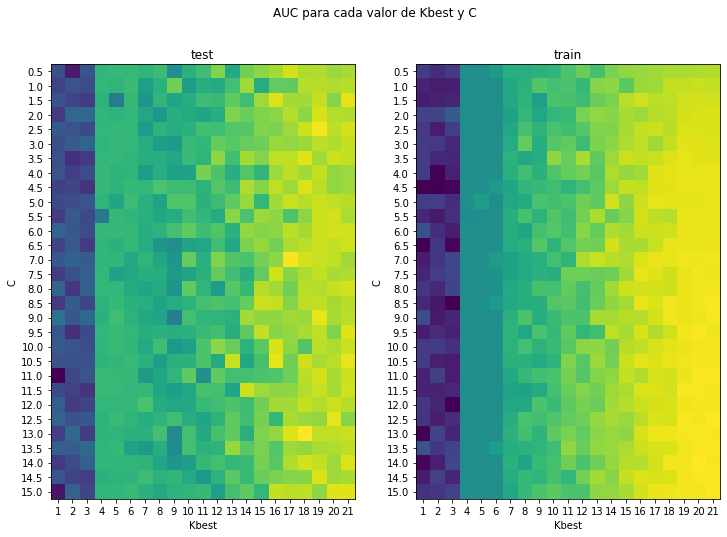

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Definamos la matriz X
campos = ['edad_mujer', 'educacion_mujer', 'numero_hijos',  'tuvo_hijos', #'educacion_hombre', 'religion_mujer', 'mujer_trabaja', 
        'ocupacion_hombre', 'nivel_vida',
       'exposicion_medios'] # Lista que contiene las features de interés.

X = indonesia[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = np.array(indonesia['anticoncepcion']) # Nuestra etiqueta sigue siende la misma de antes
X = np.concatenate((X, X**2, X**3), axis=1) # agrego features elevados a potencias, terminan siendo #campos*3


#c_values = [round(i, 1) for i in np.arange(0.2, 5.2, 0.2)]
c_values = [round(i, 1) for i in np.arange(0.5, 15.5, 0.5)] #[0.5, 1, 2, 3, 4, 5, 10, 20, 30]
k_values = range(1, len(campos)*3+1)

AUC_promedio_test = np.zeros((len(c_values),len(k_values)))
AUC_promedio_train = np.zeros((len(c_values),len(k_values)))

c_index = 0
k_index = 0
Best_auc = 0
for c in c_values:
  k_index = 0

  for Kbest in k_values:
    skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
    skf.get_n_splits(X, y) # arma los folds a partir de los datos

    auc_values_fs_test =  []  # aca es donde van a ir a parar los indices de los features seleccionados en cada fold
    selected_features= np.array([]).reshape(0,X.shape[1]) 

    auc_values_fs_train =  []

    for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
        X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
        y_train, y_test = y[train_index], y[test_index]     # idem con los targets

        scaler = MinMaxScaler() # escaleo por separado ambos sets
        scaler.fit(X_train) 
        X_train = scaler.transform(X_train)

        scaler = MinMaxScaler() # escaleo por separado ambos sets
        scaler.fit(X_test) 
        X_test = scaler.transform(X_test)

        selector = SelectKBest(k=Kbest) # por defecto, usa el F score de ANOVA y los Kbest features
        selector.fit(X_train, y_train) # encuentro los F scores 
        X_train_fs = selector.transform(X_train) # me quedo con los features mejor rankeados en el set de entrenamiento
        X_test_fs = selector.transform(X_test) # me quedo con los features mejor rankeados en el set de evaluacion
        features = np.array(selector.get_support()).reshape((1,-1)) # esto me pone True si la variable correspondiente fue seleccionada y False sino

        selected_features =  np.concatenate((selected_features,features),axis=0)

        regLog = LogisticRegression(penalty = 'l2', C = c)#, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
        regLog.fit(X_train_fs, y_train) # Ajustamos el modelo con los datos de entrenamiento


        probas_test = regLog.predict_proba(X_test_fs)  # probabilidades con datos de evaluación
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
        auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación
        auc_values_fs_test.append(auc_test)

        probas_train = regLog.predict_proba(X_train_fs)
        auc_train = roc_auc_score(y_train, probas_train[:,1]) #  AUC con datos de entrenamiento
        auc_values_fs_train.append(auc_train)

    #print(f'Agarrando los {Kbest} mejores features, el AUC_test y AUC_train promedio es:')
    #print(np.mean(auc_values_fs_test), np.mean(auc_values_fs_train))

    AUC_promedio_test[c_index, k_index] = np.mean(auc_values_fs_test)
    AUC_promedio_train[c_index, k_index] = np.mean(auc_values_fs_train)
    
    if np.mean(auc_values_fs_test) > Best_auc:
      Best_auc = np.mean(auc_values_fs_test)
      Best_features = selected_features
    
    k_index +=1

  c_index +=1

#

index_to_c = dict(zip(range(len(c_values)), c_values))
index_to_k = dict(zip(range(len(k_values)), k_values))


fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].imshow(AUC_promedio_test)
ax[1].imshow(AUC_promedio_train)
fig.suptitle("AUC para cada valor de Kbest y C")
titulo = "test"
for j in [0, 1]:
  ax[j].set_title(titulo)
  titulo = "train"
  ax[j].set_xticks(np.arange(len(k_values)))
  ax[j].set_xticklabels(k_values)
  ax[j].set_yticks(np.arange(len(c_values)))
  ax[j].set_yticklabels(c_values)
  ax[j].set_xlabel("Kbest")
  ax[j].set_ylabel("C")




In [ ]:
index_to_c = dict(zip(range(len(c_values)), c_values))
index_to_k = dict(zip(range(len(k_values)), k_values))

maximo = AUC_promedio_test.max()
posicionMax = np.unravel_index(np.argmax(AUC_promedio_test, axis=None), AUC_promedio_test.shape)
c_Max = index_to_c[posicionMax[0]]
k_Max = index_to_k[posicionMax[1]]
print(f"El mejor AUC es de {maximo} se obtuvo con k = {k_Max} y c = {c_Max}.")
print(Best_features)

El mejor AUC es de 0.7784468617801952 se obtuvo con k = 18 y c = 13.0.
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.]]


Uso mejor modelo.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
  X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
  y_train, y_test = y[train_index], y[test_index]     # idem con los targets

  scaler = MinMaxScaler() # escaleo por separado ambos sets
  scaler.fit(X_train) 
  X_train = scaler.transform(X_train)

  scaler = MinMaxScaler() # escaleo por separado ambos sets
  scaler.fit(X_test) 
  X_test = scaler.transform(X_test)

  selector = SelectKBest(k=k_Max) # por defecto, usa el F score de ANOVA y los Kbest features
  selector.fit(X_train, y_train) # encuentro los F scores 
  X_train_fs = selector.transform(X_train) # me quedo con los features mejor rankeados en el set de entrenamiento
  X_test_fs = selector.transform(X_test) # me quedo con los features mejor rankeados en el set de evaluacion
  features = np.array(selector.get_support()).reshape((1,-1)) # esto me pone True si la variable correspondiente fue seleccionada y False sino

  selected_features =  np.concatenate((selected_features,features),axis=0)

  regLog_best = LogisticRegression(penalty = 'l2', C = c_Max)#, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
  regLog_best.fit(X_train_fs, y_train) # Ajustamos el modelo con los datos de entrenamiento


  probas_test = regLog_best.predict_proba(X_test_fs)  # probabilidades con datos de evaluación
  fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
  auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación



In [ ]:
auc_test



0.8426573426573426

Paso a generar las probas a entregar.


In [ ]:
path = './data/anticoncepcion_indonesia_test.csv'
df_test = pd.read_csv(path)
df_test.columns
df_test["tuvo_hijos"] = (df_test["numero_hijos"] > 0)*1

In [ ]:
X_final = df_test[campos].values 
X_final = np.concatenate((X_final, X_final**2, X_final**3), axis=1) 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_train) 
X_train = scaler.transform(X_train)

scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_test) 
X_test = scaler.transform(X_test)

scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_final) 
X_final = scaler.transform(X_final)

selector = SelectKBest(k=k_Max) # por defecto, usa el F score de ANOVA y los Kbest features
selector.fit(X_train, y_train) # encuentro los F scores 
X_train_fs = selector.transform(X_train) # me quedo con los features mejor rankeados en el set de entrenamiento
X_test_fs = selector.transform(X_test) # me quedo con los features mejor rankeados en el set de evaluacion
X_final_fs = selector.transform(X_final)

regLog_best = LogisticRegression(penalty = 'l2', C = c_Max)
regLog_best.fit(X_train_fs, y_train) 


probas_final = regLog_best.predict_proba(X_final_fs)  
probas_test =  regLog_best.predict_proba(X_test_fs)  
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación 
auc_test

0.798941798941799

In [ ]:
probas_final


array([[0.75827034, 0.24172966],
       [0.99545148, 0.00454852],
       [0.79902844, 0.20097156],
       ...,
       [0.95519605, 0.04480395],
       [0.94327055, 0.05672945],
       [0.6806528 , 0.3193472 ]])